# Paper Script 4.5: Flint Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

import torch
from torch import nn
from torch.autograd.functional import jacobian


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from filterpy.kalman import *

# Helper functions:
from matdiv import matdiv
from KalmanPredict import KalmanPredict
from DKF_filtering import DKF_filtering
from DKF_NN import train_nn, predict_nn
from nw_est import nw_est
from optimize_sx import optimize_sx
from DKF_LSTM import LSTM1, run_lstm

### 1) Load Preprocessed Data

In [2]:
procd_velocities = np.load('flint-data-preprocessing/procd_velocities.npy', allow_pickle=True)
procd_spikes = np.load('flint-data-preprocessing/procd_spikes.npy', allow_pickle=True)

### 2) Setup

In [3]:
# Fix the RNG state.
rng = np.random.default_rng(42)
torch.manual_seed(42)


dz = 2  # Dimension of z
dx = 10 # Dimension of x

# Specify train (idx0) and test (idx1) indices:
idx0 = np.arange(0,5000)
idx1 = np.arange(5000, 6000)
n0 = len(idx0)
n1 = len(idx1)


columns = ['zero', 'K',
           'DKF_NN', # 'DKF_NN_robust',
           'DKF_GP', # 'DKF_GP_robust',
           'DKF_NW', # 'DKF_NW_robust',
           'DKF_LSTM', # 'LSTM',
           'EKF', 'UKF']

zpred = pd.DataFrame(columns=columns, dtype=object) # Predicted z-variables (velocities).
rtime = pd.DataFrame(columns=columns) # Runtime
rmse  = pd.DataFrame(columns=columns) # Root mean squared error
nrmse = pd.DataFrame(columns=columns) # Normalized root mean squared error.
maae  = pd.DataFrame(columns=columns) # Mean absolute angle error

### 3) For each dataset, run filtering

In [4]:
# The authors only ran through 6 subjects/trials, but feel free to try do more.
# However, certain experiments do not have 6000 samples.
for iRun in range(6):
    print(f'\nIteration {iRun}:')

    vel = procd_velocities[iRun]
    spk = procd_spikes[iRun]
    
    # Shift data so that velocity data is paired with correct neural data.
    z = vel[1:].T
    x = spk[:-1].T
    
    # Split into train and test
    z0 = z[:, idx0]
    z1 = z[:, idx1]
    x0 = x[:, idx0]
    x1 = x[:, idx1]
    
    # Convert training and test data to tall Tensors.
    z0_tensor = torch.from_numpy(z0).float().T
    z1_tensor = torch.from_numpy(z1).float().T
    x0_tensor = torch.from_numpy(x0).float().T
    x1_tensor = torch.from_numpy(x1).float().T
    
    
    '''
    0) Zero Prediction --------------------------------------------
    '''
    
    # Constant baseline "no prediction" at mean
    zpred.loc[iRun, 'zero'] = z1 * 0
    
    
    '''
    1) Kalman Filter ----------------------------------------------
    '''
    # Learn parameters for Kalman filter
    z01 = z0[:, 1:]
    z00 = z0[:, :-1]
    A0 = matdiv(z01, z00)
    G0 = (z01 - A0.dot(z00)).dot((z01 - A0.dot(z00)).T) / n0
    C0 = matdiv(x0, z0)
    S0 = (x0 - C0.dot(z0)).dot((x0 - C0.dot(z0)).T) / n0
    
    # Run Kalman Filter
    tic = time.time()
    result, _ = KalmanPredict(x=x1, A=A0,
                              C=C0, S=S0, G=G0,
                              mu0=np.zeros(dz),
                              V0=np.cov(z0.T, rowvar=False))
    zpred.loc[iRun, 'K'] = result
    rtime.loc[iRun, 'K'] = time.time() - tic
    
    
    
    '''
    2) DKF-NN ----------------------------------------------------
    '''
    
    print('DKF-NN')
    
    # Split x0 and z0 into training and hold-out test data, then convert to tall Tensors:
    
    # Randomly shuffle the array of training data indices [0, 1, ..., idx0].
    indices  = rng.permutation(idx0)
    # 70% of the training data will serve for model training.
    # The other 30% will serve as held-out trainingdata for regression calibration.
    boundary = int(0.7 * n0)
    
    # Get x0_test and z0_test, which are the test subset of x0.
    x0_train = x0[:, indices[:boundary]]
    x0_test  = x0[:, indices[boundary:]]
    
    z0_train = z0[:, indices[:boundary]]
    z0_test  = z0[:, indices[boundary:]]
    
    # Get the tensor forms of x0_train/test and z0_train/test.
    # They will be tall Tensors.
    x0_train_tensor = torch.from_numpy(x0_train).float().T
    x0_test_tensor  = torch.from_numpy(x0_test).float().T
    
    z0_train_tensor = torch.from_numpy(z0_train).float().T
    z0_test_tensor  = torch.from_numpy(z0_test).float().T
    

    n0_train = x0_train.shape[1] # length of training data from training set.
    n0_test  = x0_test.shape[1]  # length of heldout (test) data from training set.
    
    
    input_size = dx
    hidden_sizes = [10, 10]
    output_size = dz
    
    model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                          nn.Tanh(),
                          nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                          nn.Tanh(),
                          nn.Linear(hidden_sizes[0], output_size))


    train_nn(model, learning_rate=1e-3, weight_decay=1e-4, iterations=4000, # 2000
             x_train=x0_train_tensor,
             y_train=z0_train_tensor)  


    # Calibrate prediction method using held-out data, then get predicted data from NN.
    u_means_nn, u_vars_nn, tic = predict_nn(model=model, x0_test=x0_test, x0_test_tensor=x0_test_tensor,
                                            z0_test=z0_test, x1=x1, x1_tensor=x1_tensor)

    # predict DKF-NN
    zpred.loc[iRun, 'DKF_NN'] = DKF_filtering(means = u_means_nn, _vars = u_vars_nn, A = A0, G = G0, VZ = np.cov(z0.T, rowvar=False))
    rtime.loc[iRun, 'DKF_NN'] = time.time() - tic;
        
        
        
    
    '''
    3) DKF-GP ----------------------------------------------------------------
    '''
        
    print('DKF-GP')
        
    '''
    Use one Gaussian process for both dimensions of z,
    unlike in the paper, which used two processes, one for each dimension of z.
    Also unlike the paper, the hyperparameters are mostly fixed in these GP regressions.
    The kernel used is the default kernel of GaussianProcessRegressor.
    These simplifications were made to because of:
        * The difficulty of using the GPML Matlab package in Python (especially given its age).
        * The GaussianProcessRegressor optimizations often yielding very high kernel bandwidths.
        * The big improvement in training time when using a simpler model.
    '''
    if True:
        gpr = fit_gpgpr = GaussianProcessRegressor(random_state=0, alpha=0.1, normalize_y=False).fit(x0_train.T, z0_train.T)
        zgp0_test = gpr.predict(x0_test.T).T

        z0resgp = zgp0_test - z0_test


        z0resOutergp = np.zeros((dz**2, n0_test))
        for t in range(n0_test):
            z0resOutergp[:, t] = np.outer(z0resgp[:, t], z0resgp[:, t]).flatten()


        sxresoptgp = optimize_sx(ztest = x0_test,
                                 xtrain = z0resOutergp,
                                 ztrain = x0_test)


        tic = time.time()

        u_means_gp = np.zeros((dz, n1))
        u_vars_gp = np.zeros((dz, dz, n1))

        for t in range(n1):
            u_means_gp[:,t] = gpr.predict(x1[:, t:t+1].T)[0]

            u_vars_gp[:, :, t] =  nw_est(ztest = x1[:, t:t+1].T,
                                         xtrain = z0resOutergp.T,
                                         ztrain = x0_test.T,
                                         sz2 = sxresoptgp).reshape((dz, dz))


        # predict DKF-GP
        zpred.loc[iRun, 'DKF_GP'] = DKF_filtering(means = u_means_gp, _vars = u_vars_gp, A = A0, G = G0, VZ = np.cov(z0.T, rowvar=False))
        rtime.loc[iRun, 'DKF_GP'] = time.time() - tic
    
    
    '''
    4) DKF-NW -----------------------------------------------------------------
    '''
    if True:
        print('DKF-NW')

        sxopt = optimize_sx(ztest = x0_train,
                            xtrain = z0_train,
                            ztrain = x0_train)


        z0resnw = np.zeros_like(z0_test)

        for i in range(n0_test):
            z0resnw[:, i] = nw_est(ztest = x0_test[:, i:i+1].T,
                                   xtrain = z0_train.T,
                                   ztrain = x0_train.T,
                                   sz2 = sxopt)

        z0resnw = z0resnw - z0_test


        z0resOuternw = np.zeros((dz**2, n0_test))

        for t in range(n0_test):
            z0resOuternw[:, t] = np.outer(z0resnw[:, t], z0resnw[:, t]).flatten()



        sxresoptnw = optimize_sx(ztest = x0_test,
                                 xtrain = z0resOuternw,
                                 ztrain = x0_test)


        # Predict nw
        tic = time.time()

        u_means_nw = np.zeros((dz, n1))
        u_vars_nw = np.zeros((dz, dz, n1))

        for t in range(n1):
            u_means_nw[:, t] = nw_est(ztest = x1[:, t:t+1].T,
                                      xtrain = z0.T,
                                      ztrain = x0.T,
                                      sz2 = sxopt)

            u_vars_nw[:, :, t] = nw_est(ztest = x1[:, t:t+1].T,
                                        xtrain = z0resOuternw.T,
                                        ztrain = x0_test.T,
                                        sz2 = sxresoptnw).reshape((dz, dz))


        # Predict DKF-NW
        zpred.loc[iRun, 'DKF_NW'] = DKF_filtering(means = u_means_nw, _vars = u_vars_nw, A = A0, G = G0, VZ = np.cov(z0.T, rowvar=False))
        rtime.loc[iRun, 'DKF_NW'] = time.time() - tic;


    
    
    
    '''
    5) LSTM --------------------------------------------------------------
    '''

    if True:
        print('DKF-LSTM')

        input_size = 10 #number of features
        hidden_size = 2 #number of features in hidden state
        num_layers = 1 #number of stacked lstm layers

        num_classes = 2 #number of output classes


        lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers) #our lstm class 

        u_means_lstm, u_vars_lstm, tic = run_lstm(lstm=lstm1, num_epochs=2000, learning_rate=1e-3, weight_decay=1e-4,
                                                   x0=x0, z0=z0, boundary=boundary,
                                                   x1=x1, x1_tensor=x1_tensor)


        zpred.loc[iRun, 'DKF_LSTM'] = DKF_filtering(means = u_means_lstm, _vars = u_vars_lstm, A = A0, G = G0, VZ = np.cov(z0.T, rowvar=False))
        rtime.loc[iRun, 'DKF_LSTM'] = time.time() - tic
    
    
    
    
    '''
    6) EKF ------------------------------------------------------------
    '''
    
    print('EKF')
    
    
    # Train a model to learn R2 -> R10 transformation (z -> x)

    input_size = dz
    hidden_sizes = [10, 10]
    output_size = dx

    nnUKF = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                          nn.Tanh(),
                          nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                          nn.Tanh(),
                          nn.Linear(hidden_sizes[0], output_size))


    train_nn(nnUKF, learning_rate=1e-3, weight_decay=1e-4, iterations=4000, # 2000
             x_train=z0_train_tensor,
             y_train=x0_train_tensor)  
    
    
    xnn0 = nnUKF(z0_test_tensor)
    errEstUKF = (xnn0 - x0_test_tensor).detach().numpy().T
    covEstUKF = np.cov(errEstUKF.T, rowvar=False)
    

    '''
    Extended Kalman Filter:

    F  = A0 (state transition matrix)
    Hx = nnUKF (observation function)

    Initial state guess = [0, 0]

    Process noise = G0
    Measurement noise = covEstUKF
    State covariance = cov(z0.T, rowvar=False)

    '''

    # Unlike the UKF class, the EKF class uses 2D column observations.
    def Hx(x):
        global nnUKF

        tensor = torch.from_numpy(x.flatten()).float()
        return nnUKF(tensor).detach().numpy().reshape(-1, 1)

    def HJacobian(x, *hx_args):
        '''
        Return the Jacobian dH/dx around the point x.
        '''
        global nnUKF

        tensor = torch.from_numpy(x.flatten()).float()

        return jacobian(nnUKF, tensor).detach().numpy()    

    '''
    The notation is a bit confusing with the filterpy module, since
    EKF and UKF's x is the latent state (our z), while
    EKF and UKF's z is observations (our x).
    '''

    tic = time.time()

    EKF = ExtendedKalmanFilter(dim_x=dz, dim_z=dx)

    EKF.F = A0
    EKF.Q = G0 # process noise
    EKF.R = covEstUKF # observation noise
    EKF.P = np.cov(z0.T, rowvar=False) # Initial state covariance

    zEKF = np.zeros((dz, n1))

    for i in range(n1):
        EKF.predict_update(z=x1[:, i:i+1],
                           HJacobian=HJacobian,
                           Hx=Hx)
        zEKF[:, i] = EKF.x.flatten()

    zpred.loc[iRun, 'EKF'] = zEKF
    rtime.loc[iRun, 'EKF'] = time.time() - tic
    
    
    '''
    7) UKF -----------------------------------------------------------
    '''
    
    print('UKF')

    def fx(x, dt):
        global A0
        return A0.dot(x) # Ignore dt.

    # Unlike the EKF class, the UKF class uses one-dimensional observations.
    def Hx_1D(x):
        global nnUKF

        tensor = torch.from_numpy(x.flatten()).float()
        return nnUKF(tensor).detach().numpy()

    tic = time.time()

    # Use MerweScaledSigmaPoints for alpha, beta, kappa parameters of Unscented Transform.
    points = MerweScaledSigmaPoints(2, alpha=1e-3, beta=2, kappa=0)
    UKF = UnscentedKalmanFilter(dim_x=dz, dim_z=dx,
                                dt=1, hx=Hx_1D, fx=fx,
                                points=points)

    UKF.Q = G0 # process noise
    UKF.R = covEstUKF # observation noise
    UKF.P = np.cov(z0.T, rowvar=False) # Initial state covariance


    zUKF = np.zeros((dz, n1))

    for i in np.arange(n1):
        UKF.predict()
        UKF.update(z=x1[:, i])
        zUKF[:, i] = UKF.x.flatten()

    zpred.loc[iRun, 'UKF'] = zUKF
    rtime.loc[iRun, 'UKF'] = time.time() - tic
    
    
    
    
    '''
    Final step: Calculate and report performance.
    '''
    
    def raw2abs_ang_err(ae):
        return np.abs([ae - 2*np.pi, ae, ae + 2*np.pi]).min()

    for method in zpred.columns:
        # Skip any entry without data.
        zF = zpred.loc[iRun, method]
        if zF is np.NaN: continue
        
        rmse.loc[iRun, method] = np.sqrt(np.mean((zF - z1)**2)) # Store root mean-squared error
        
        norm = np.sqrt(np.mean(z1**2))
        nrmse.loc[iRun, method] = rmse.loc[iRun, method] / norm # Calculate normalized RMSE, such that predicting all zeros maps to 1.
        
        raw_ang_err = np.arctan2(zF[1], zF[0]) - np.arctan2(z1[1], z1[0])
        abs_ang_error = np.array([raw2abs_ang_err(x) for x in raw_ang_err])
        maae.loc[iRun, method] = abs_ang_error.mean() # Store mean absolute angle error.


Iteration 0:
DKF-NN


C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\nw_est.py:26: RuntimeWarning: invalid value encountered in true_divide
  f_est = xP / sP
C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\optimize_sx.py:42: RuntimeWarning: Mean of empty slice
  return np.nanmean((xtrain - preds) ** 2)


DKF-GP


C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\nw_est.py:26: RuntimeWarning: invalid value encountered in true_divide
  f_est = xP / sP
C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\optimize_sx.py:42: RuntimeWarning: Mean of empty slice
  return np.nanmean((xtrain - preds) ** 2)


DKF-NW


C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\nw_est.py:26: RuntimeWarning: invalid value encountered in true_divide
  f_est = xP / sP
C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\optimize_sx.py:42: RuntimeWarning: Mean of empty slice
  return np.nanmean((xtrain - preds) ** 2)


DKF-LSTM
EKF
UKF

Iteration 1:
DKF-NN
DKF-GP


C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\nw_est.py:26: RuntimeWarning: invalid value encountered in true_divide
  f_est = xP / sP
C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\optimize_sx.py:42: RuntimeWarning: Mean of empty slice
  return np.nanmean((xtrain - preds) ** 2)


DKF-NW


C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\nw_est.py:26: RuntimeWarning: invalid value encountered in true_divide
  f_est = xP / sP
C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\optimize_sx.py:42: RuntimeWarning: Mean of empty slice
  return np.nanmean((xtrain - preds) ** 2)


DKF-LSTM
EKF
UKF

Iteration 2:
DKF-NN
DKF-GP


C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\nw_est.py:26: RuntimeWarning: invalid value encountered in true_divide
  f_est = xP / sP
C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\optimize_sx.py:42: RuntimeWarning: Mean of empty slice
  return np.nanmean((xtrain - preds) ** 2)


DKF-NW


C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\nw_est.py:26: RuntimeWarning: invalid value encountered in true_divide
  f_est = xP / sP
C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\optimize_sx.py:42: RuntimeWarning: Mean of empty slice
  return np.nanmean((xtrain - preds) ** 2)


DKF-LSTM
EKF
UKF

Iteration 3:
DKF-NN
DKF-GP


C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\nw_est.py:26: RuntimeWarning: invalid value encountered in true_divide
  f_est = xP / sP
C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\optimize_sx.py:42: RuntimeWarning: Mean of empty slice
  return np.nanmean((xtrain - preds) ** 2)


DKF-NW


C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\nw_est.py:26: RuntimeWarning: invalid value encountered in true_divide
  f_est = xP / sP
C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\optimize_sx.py:42: RuntimeWarning: Mean of empty slice
  return np.nanmean((xtrain - preds) ** 2)


DKF-LSTM
EKF
UKF

Iteration 4:
DKF-NN
DKF-GP


C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\nw_est.py:26: RuntimeWarning: invalid value encountered in true_divide
  f_est = xP / sP
C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\optimize_sx.py:42: RuntimeWarning: Mean of empty slice
  return np.nanmean((xtrain - preds) ** 2)


DKF-NW


C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\nw_est.py:26: RuntimeWarning: invalid value encountered in true_divide
  f_est = xP / sP
C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\optimize_sx.py:42: RuntimeWarning: Mean of empty slice
  return np.nanmean((xtrain - preds) ** 2)


DKF-LSTM
EKF
UKF

Iteration 5:
DKF-NN
DKF-GP


C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\nw_est.py:26: RuntimeWarning: invalid value encountered in true_divide
  f_est = xP / sP
C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\optimize_sx.py:42: RuntimeWarning: Mean of empty slice
  return np.nanmean((xtrain - preds) ** 2)


DKF-NW


C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\nw_est.py:26: RuntimeWarning: invalid value encountered in true_divide
  f_est = xP / sP
C:\Users\josue\Documents\Python Scripts\DKF\Python_Paper_45\optimize_sx.py:42: RuntimeWarning: Mean of empty slice
  return np.nanmean((xtrain - preds) ** 2)


DKF-LSTM
EKF
UKF


### 4) Calculate averages, then Display Results

In [5]:
nrmse.loc['avg'] = nrmse.mean()
maae.loc['avg'] = maae.mean()

In [6]:
table1 = nrmse[['K', 'DKF_NW', 'DKF_GP', 'DKF_NN', 'DKF_LSTM', 'EKF', 'UKF']].T.astype(float)
#table1 = nrmse
for idx in table1.index:
    if idx == 'K': continue
        
    # Convert to a percentage relative to 'K'
    table1.loc[idx] = table1.loc[idx] / table1.loc['K'] - 1
    
    # Convert to a percentage string
    table1.loc[idx] = table1.loc[idx].map(lambda n: '{:.0%}'.format(n))
    

print('Normalized Root Mean Square Error:')
display(table1)

Normalized Root Mean Square Error:


,0,1,2,3,4,5,avg
K,0.764696,0.944812,0.787808,0.791731,0.77874,0.7613,0.804848
DKF_NW,-19%,-18%,-9%,-21%,-19%,-20%,-18%
DKF_GP,-7%,-10%,-8%,-9%,-12%,-9%,-9%
DKF_NN,-23%,-10%,-5%,-14%,-20%,-21%,-15%
DKF_LSTM,-8%,30%,-6%,-4%,-10%,-12%,-1%
EKF,2%,8%,9%,19%,17%,12%,11%
UKF,1%,-2%,7%,19%,9%,12%,7%


In [7]:
table2 = maae[['K', 'DKF_NW', 'DKF_GP', 'DKF_NN', 'DKF_LSTM', 'EKF', 'UKF']].T.astype(float)

for idx in table2.index:
    if idx == 'K': continue
        
    # Convert to a percentage relative to 'K'
    table2.loc[idx] = table2.loc[idx] / table2.loc['K'] - 1
    
    # Convert to a percentage string
    table2.loc[idx] = table2.loc[idx].map(lambda n: '{:.0%}'.format(n))
    

print('Mean absolute angle error:')
display(table2)

Mean absolute angle error:


,0,1,2,3,4,5,avg
K,0.884358,0.956565,1.025778,0.93013,0.966334,0.926246,0.948235
DKF_NW,-14%,-0%,-21%,-15%,-25%,-29%,-17%
DKF_GP,-2%,12%,-18%,-4%,-15%,-20%,-8%
DKF_NN,-9%,0%,-15%,-10%,-17%,-22%,-12%
DKF_LSTM,-4%,6%,-12%,-7%,-14%,-11%,-7%
EKF,-1%,8%,2%,4%,-4%,-0%,2%
UKF,-2%,5%,1%,2%,-9%,-3%,-1%


### Optional: plot

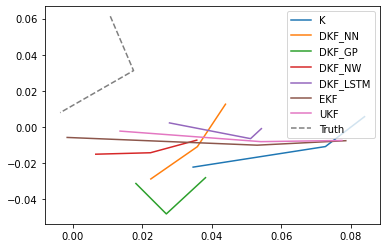

In [8]:
iRun_plot = 2
T = np.arange(40, 43)

for method in zpred.columns[1:]:
    # Don't try to plot any entries that aren't filled in.
    if type(zpred.loc[iRun_plot, method]) != np.ndarray: continue
        
    # Plot the graph associated with method.
    plt.plot(zpred.loc[iRun_plot, method][0, T], zpred.loc[iRun_plot, method][1, T], label=method)
    
# Plot the ground truth state.
plt.plot(z1[0, T], z1[1, T], '--', label='Truth')
plt.legend()
plt.show()